I. Import Library

In [101]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import functional as F
from PIL import Image
from tqdm import tqdm

II. Prepare Dataset

In [102]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [103]:
train_df = pd.read_csv('digit-recognizer/train.csv')
test_df = pd.read_csv('digit-recognizer/test.csv')

class MNISTDataset(Dataset):
    def __init__(self, dataframe, is_train=True, transform=None):
        self.is_train = is_train
        self.transform = transform
        
        if is_train:
            self.labels = dataframe['label'].values
            self.images = dataframe.drop('label', axis=1).values.reshape(-1, 28, 28).astype(np.uint8)
        else:
            self.images = dataframe.values.reshape(-1, 28, 28).astype(np.uint8)
            self.labels = None
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_train:
            label = self.labels[idx]
            return image, torch.tensor(label, dtype=torch.long)
        else:
            return image

train_data = MNISTDataset(train_df, is_train=True, transform=transform)
test_data = MNISTDataset(test_df, is_train=False, transform=transform)


III. DataLoader

In [104]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Define the CNN model

In [105]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)  

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 1 * 1, 128)
        self.fc2 = nn.Linear(128, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))  

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x


Create model, loss function, optimizer

In [106]:
model = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Training loop

In [107]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_df_split, val_df_split = train_test_split(
    train_df, test_size=0.2, random_state=42
)

train_dataset = MNISTDataset(train_df_split, is_train=True, transform=transform)
val_dataset   = MNISTDataset(val_df_split,   is_train=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)

epochs = 30
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{epochs}",
        leave=False
    )

    for images, labels in train_bar:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        train_bar.set_postfix(
            loss=f"{loss.item():.4f}",
            acc=f"{100 * correct / total:.2f}%"
        )

    train_loss /= len(train_loader)
    train_acc = 100 * correct / total

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
    f"Epoch {epoch+1:02d}/{epochs} | "
    f"acc: {train_acc:.2f}% - loss: {train_loss:.4f} | "
    f"val_acc: {val_acc:.2f}% - val_loss: {val_loss:.4f}"
)

Epoch 01/30 | acc: 89.05% - loss: 0.3459 | val_acc: 96.43% - val_loss: 0.1172


Epoch 02/30 | acc: 97.16% - loss: 0.0941 | val_acc: 97.10% - val_loss: 0.0914


Epoch 03/30 | acc: 97.87% - loss: 0.0684 | val_acc: 98.27% - val_loss: 0.0586


Epoch 04/30 | acc: 98.36% - loss: 0.0515 | val_acc: 98.20% - val_loss: 0.0614


Epoch 05/30 | acc: 98.66% - loss: 0.0414 | val_acc: 98.12% - val_loss: 0.0616


Epoch 06/30 | acc: 98.92% - loss: 0.0346 | val_acc: 98.48% - val_loss: 0.0510


Epoch 07/30 | acc: 99.08% - loss: 0.0279 | val_acc: 98.49% - val_loss: 0.0540


Epoch 08/30 | acc: 99.22% - loss: 0.0248 | val_acc: 98.55% - val_loss: 0.0512


Epoch 09/30 | acc: 99.28% - loss: 0.0220 | val_acc: 98.31% - val_loss: 0.0630


Epoch 10/30 | acc: 99.32% - loss: 0.0206 | val_acc: 98.56% - val_loss: 0.0447


Epoch 11/30 | acc: 99.48% - loss: 0.0156 | val_acc: 98.62% - val_loss: 0.0464


Epoch 12/30 | acc: 99.62% - loss: 0.0120 | val_acc: 98.36% - val_loss: 0.0580


Epoch 13/30 | acc: 99.58% - loss: 0.0120 | val_acc: 98.38% - val_loss: 0.0661


Epoch 14/30 | acc: 99.53% - loss: 0.0148 | val_acc: 98.68% - val_loss: 0.0566


Epoch 15/30 | acc: 99.69% - loss: 0.0093 | val_acc: 98.63% - val_loss: 0.0589


Epoch 16/30 | acc: 99.75% - loss: 0.0084 | val_acc: 98.79% - val_loss: 0.0533


Epoch 17/30 | acc: 99.51% - loss: 0.0139 | val_acc: 98.32% - val_loss: 0.0718


Epoch 18/30 | acc: 99.67% - loss: 0.0096 | val_acc: 98.58% - val_loss: 0.0659


Epoch 19/30 | acc: 99.81% - loss: 0.0057 | val_acc: 98.55% - val_loss: 0.0601


Epoch 20/30 | acc: 99.71% - loss: 0.0094 | val_acc: 98.24% - val_loss: 0.0784


Epoch 21/30 | acc: 99.71% - loss: 0.0086 | val_acc: 98.63% - val_loss: 0.0648


Epoch 22/30 | acc: 99.84% - loss: 0.0054 | val_acc: 98.79% - val_loss: 0.0556


Epoch 23/30 | acc: 99.79% - loss: 0.0065 | val_acc: 98.64% - val_loss: 0.0680


Epoch 24/30 | acc: 99.60% - loss: 0.0130 | val_acc: 98.65% - val_loss: 0.0648


Epoch 25/30 | acc: 99.82% - loss: 0.0050 | val_acc: 98.86% - val_loss: 0.0611


Epoch 26/30 | acc: 99.88% - loss: 0.0042 | val_acc: 98.69% - val_loss: 0.0682


Epoch 27/30 | acc: 99.81% - loss: 0.0060 | val_acc: 98.79% - val_loss: 0.0647


Epoch 28/30 | acc: 99.81% - loss: 0.0059 | val_acc: 98.81% - val_loss: 0.0649


Epoch 29/30 | acc: 99.79% - loss: 0.0066 | val_acc: 98.45% - val_loss: 0.0927


Epoch 30/30 | acc: 99.87% - loss: 0.0044 | val_acc: 98.73% - val_loss: 0.0701


Loss and Accurracy

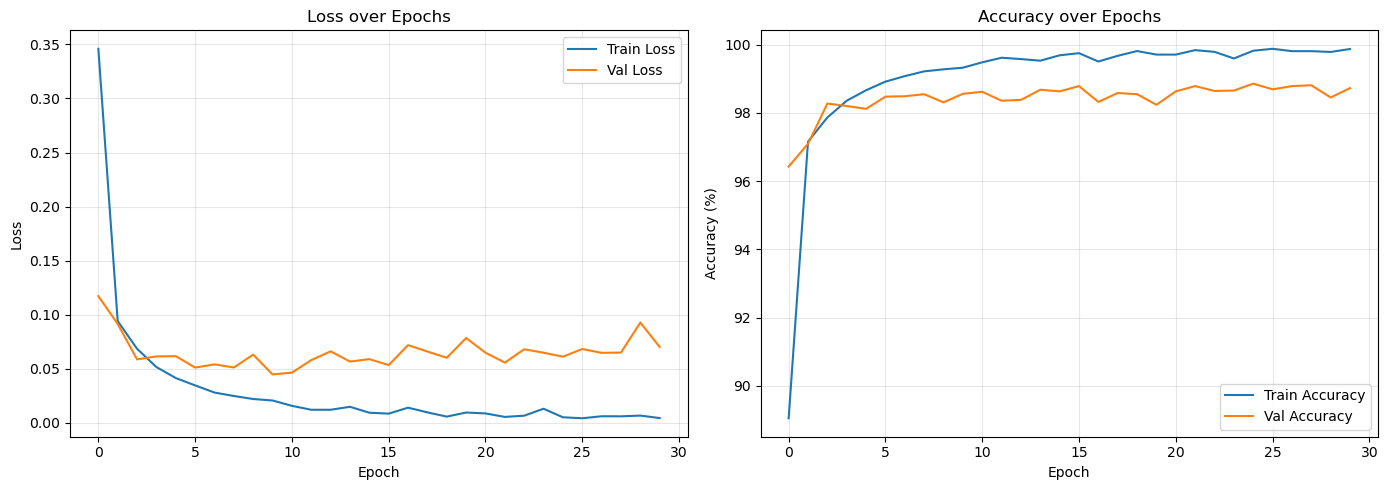

In [108]:
import matplotlib.pyplot as plt

# -------- Plot Training History --------
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Confusion Matrix

Evaluating: 100%|██████████| 132/132 [00:02<00:00, 45.49it/s]


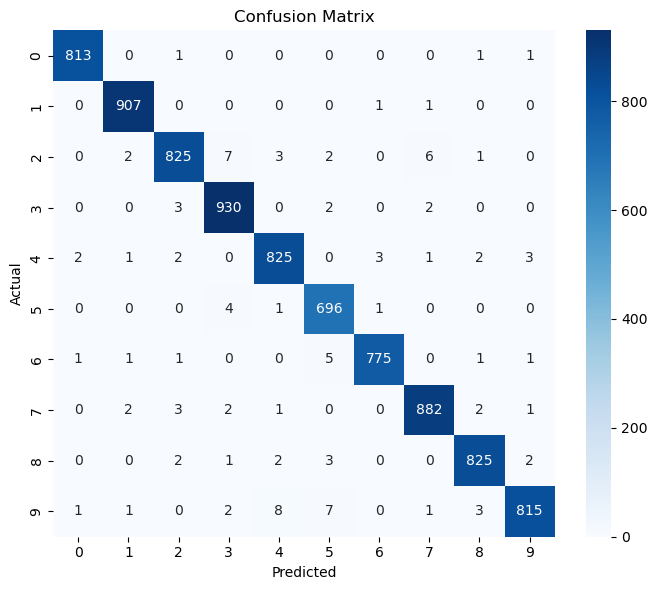

In [109]:
from sklearn.metrics import confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader_split, desc="Evaluating"):
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=range(10),
    yticklabels=range(10)
)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


In [112]:
# Calculate Validation Accuracy
model.eval()
val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (preds == labels).sum().item()

val_accuracy = (val_correct / val_total) * 100

print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(f"Correct Predictions: {val_correct} out of {val_total}")

Validation Accuracy: 98.73%
Correct Predictions: 8293 out of 8400


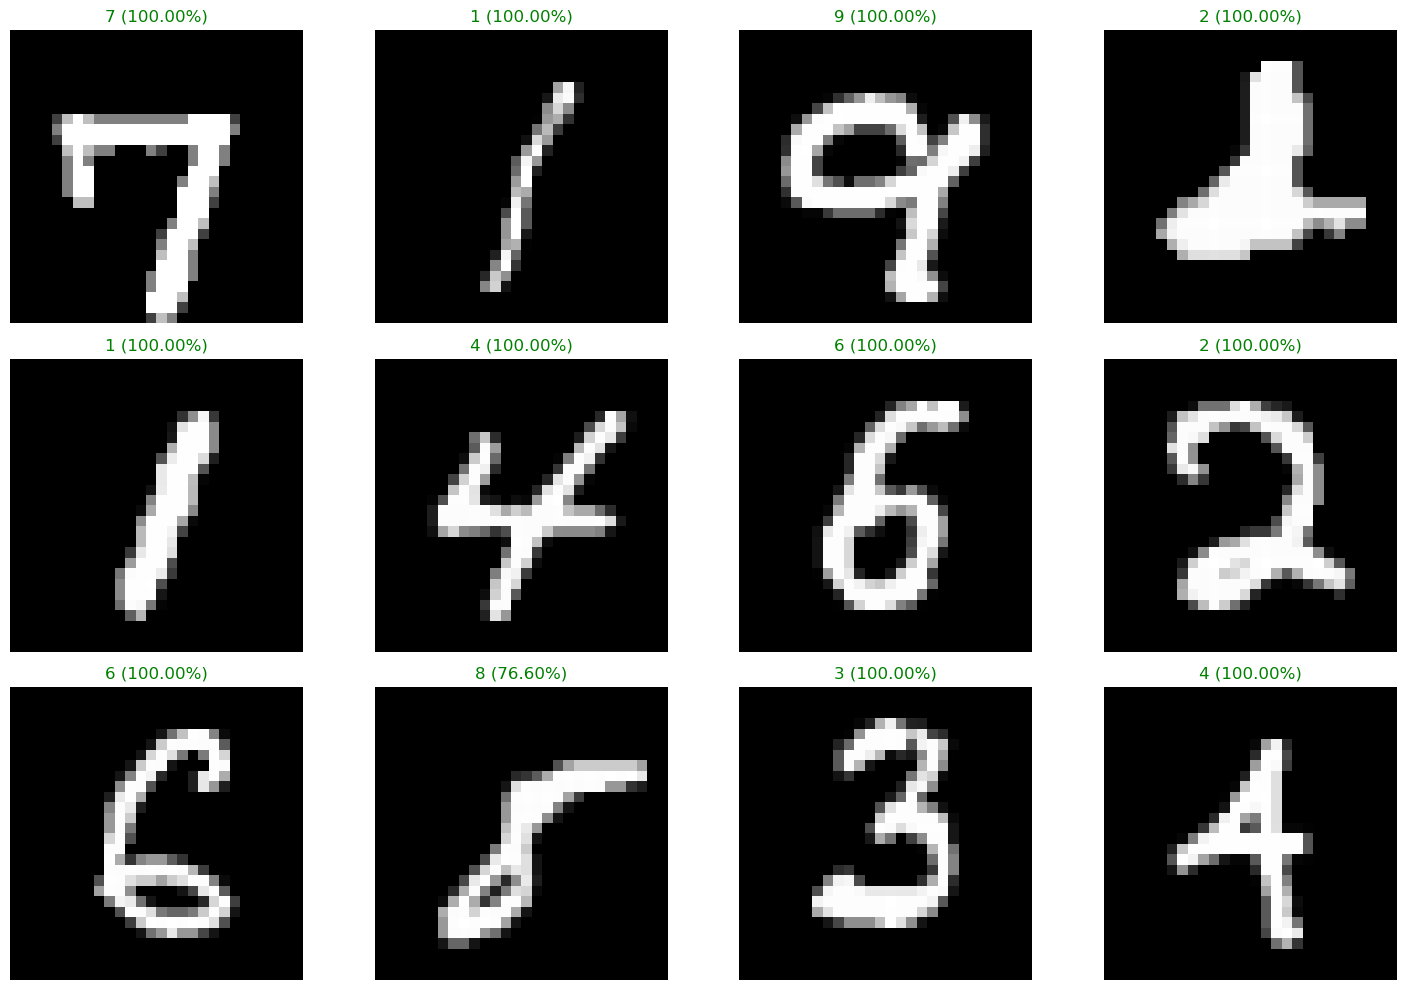

In [122]:
model.eval()

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.ravel()
indices = np.random.choice(len(test_data), 12, replace=False)

with torch.no_grad():
    for i, idx in enumerate(indices):
        img = test_data[idx].unsqueeze(0)
        output = model(img)
        pred = output.argmax(1).item()
        conf = torch.softmax(output, dim=1)[0, pred].item()

        axes[i].imshow(img.squeeze().cpu(), cmap='gray')
        axes[i].set_title(f'{pred} ({conf:.2%})', color='green', fontsize=12)
        axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
model_path = 'digit_recognizer_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Model have been saved")

Model have been saved
